In [1]:
from Envs.pendulum import PendulumEnv
import gymnasium as gym
from gymnasium.wrappers import TimeLimit

In [2]:
env = PendulumEnv()
env = TimeLimit(env, max_episode_steps=200) 

In [3]:
env.reset()

(array([-0.70250255,  0.71168125, -0.7742709 ], dtype=float32), {})

In [4]:
from stable_baselines3 import PPO
import torch

In [5]:
from MBEnvs.mb_pendulum2 import MB_PendulumEnv
env_models = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MB_env = MB_PendulumEnv(env_models, device)

In [6]:
Global_RL = PPO("MlpPolicy", MB_env)

In [7]:
agent_sb3 = SB3Agent(policy_net=Global_RL)

NameError: name 'SB3Agent' is not defined

In [ ]:
test_client = FRLClient(env=env,agent=agent_sb3, lr=0.0001, hidden_size= 256, device=device)

In [ ]:
test_client.sample_data(100)

In [ ]:
test_client.dataset_X

In [ ]:
test_client.dataset_y

In [9]:
device

device(type='cuda')

In [5]:
from sb3_contrib import TRPO
from Client_diff_Gaussian import FRLClient
from Agent import SB3Agent
import copy
from stable_baselines3.common.evaluation import evaluate_policy
import torch
import numpy as np

In [6]:
from Envs.pendulum import PendulumEnv
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
from MBEnvs.mb_pendulum2_gaussian import MB_PendulumEnv

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# initialize the client and server
timesteps_real_per_round = 500
timesteps_fc_per_round = timesteps_real_per_round * 30
epoch_per_round = 100
CLIENTS_NUM = 3
rounds_num = 30
batch_size_env_model = 128

test_dir = "Diff_Gaussian_test1"
model_tmp_path = test_dir + "/models/tmp"

env_models = []
MB_env = TimeLimit(MB_PendulumEnv(env_models,device), max_episode_steps = 200)

# Global_RL = PPO("MlpPolicy", MB_env, verbose=1)
Global_RL = TRPO("MlpPolicy", MB_env, verbose=1)

env_theta = [0.1, 0.3, 0.5, 0.7, 0.9]
real_envs = []
Clients = []
for i in range(CLIENTS_NUM):
    real_envs.append( TimeLimit(PendulumEnv(), max_episode_steps=200) )
    policy_net = Global_RL
    agent = SB3Agent(policy_net)
    client = FRLClient(real_envs[i], agent, lr = 3e-4, hidden_size = 256, device = device)
    Clients.append(client)
    env_model = copy.deepcopy(client.model)
    env_models.append(env_model)
    

    
Global_RL.env.models = env_models

Global_RL.save(model_tmp_path)

rewards_log = []

env_models = []
for round_idx in range(rounds_num):
    print('------------------------------')
    print("round: " + str(round_idx))
    for client_idx in range(len(Clients)):
        print('------------------------------')
        print("client: " + str(client_idx))
        # update policy
        Clients[client_idx].agent.policy_net = Global_RL
        # train prediction models
        Clients[client_idx].learn(timesteps_real_per_round, epoch_per_round, batch_size_env_model)
        #
        env_model = Clients[client_idx].get_prediction_model()
        env_models.append(env_model)
    
#     Server.update_env_models(env_models)

    MB_env = TimeLimit(MB_PendulumEnv(env_models,device), max_episode_steps = 200)
    
    Global_RL = TRPO.load(model_tmp_path, env = MB_env)
#     Global_RL.env.models = env_models
    #
    Global_RL.learn(total_timesteps=timesteps_fc_per_round)
    
    Global_RL.save(model_tmp_path)
#     Server.learn(timesteps_real_per_round = 10000)
    # test performance
    mean_reward, std_reward = evaluate_policy(Global_RL, real_envs[1], n_eval_episodes=10)
    rewards_log.append(mean_reward)
    print("mean_reward in real env:" + str(mean_reward))
    np.save( test_dir + "/reward_logs.npy", rewards_log)
    

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------
round: 0
------------------------------
client: 0
Epoch 1/100, Train Loss: -0.0012, Test Loss: -0.0040
Epoch 2/100, Train Loss: -0.0026, Test Loss: -0.0059
Epoch 3/100, Train Loss: -0.0040, Test Loss: -0.0079
Epoch 4/100, Train Loss: -0.0054, Test Loss: -0.0102
Epoch 5/100, Train Loss: -0.0070, Test Loss: -0.0127
Epoch 6/100, Train Loss: -0.0088, Test Loss: -0.0156
Epoch 7/100, Train Loss: -0.0108, Test Loss: -0.0187
Epoch 8/100, Train Loss: -0.0130, Test Loss: -0.0223
Epoch 9/100, Train Loss: -0.0155, Test Loss: -0.0263
Epoch 10/100, Train Loss: -0.0182, Test Loss: -0.0305
Epoch 11/100, Train Loss: -0.0207, Test Loss: -0.0343
Epoch 12/100, Train Loss: -0.0230, Test Loss: -0.0375
Epoch 13/100, Train Loss: -0.0245, Test Loss: -0.0406
Epoch 14/100, Train Loss: -0.0262, Test Loss: -0.0418
Epoch 15/100, Train Loss: -0.0276, Test Loss: -0.0452
Epoch 16/100, Train Los

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.02e+03 |
| time/              |           |
|    fps             | 302       |
|    iterations      | 1         |
|    time_elapsed    | 6         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 200       |
|    ep_rew_mean            | -1.02e+03 |
| time/                     |           |
|    fps                    | 290       |
|    iterations             | 2         |
|    time_elapsed           | 14        |
|    total_timesteps        | 4096      |
| train/                    |           |
|    explained_variance     | -0.00363  |
|    is_line_search_success | 1         |
|    kl_divergence_loss     | 0.00803   |
|    learning_rate          | 0.001     |
|    n_updates              | 1         |
|    policy_objectiv

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1191.731351493299
------------------------------
round: 1
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.2363, Test Loss: 0.2307
Epoch 2/100, Train Loss: 0.1937, Test Loss: 0.2417
Epoch 3/100, Train Loss: 0.0923, Test Loss: -0.0054
Epoch 4/100, Train Loss: 0.0041, Test Loss: 0.0717
Epoch 5/100, Train Loss: 0.0451, Test Loss: -0.0001
Epoch 6/100, Train Loss: -0.0137, Test Loss: -0.0416
Epoch 7/100, Train Loss: -0.0228, Test Loss: -0.0296
Epoch 8/100, Train Loss: -0.0210, Test Loss: -0.0251
Epoch 9/100, Train Loss: -0.0191, Test Loss: -0.0327
Epoch 10/100, Train Loss: -0.0274, Test Loss: -0.0514
Epoch 11/100, Train Loss: -0.0336, Test Loss: -0.0526
Epoch 12/100, Train Loss: -0.0329, Test Loss: -0.0519
Epoch 13/100, Train Loss: -0.0327, Test Loss: -0.0514
Epoch 14/100, Train Loss: -0.0334, Test Loss: -0.0544
Epoch 15/100, Train Loss: -0.0355, Test Loss: -0.0559
Epoch 16/100, Train Loss: -0.0362, Test Loss: -0.0559
Epoch 17/100, Train Loss: -0.

-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 200       |
|    ep_rew_mean            | -1.04e+03 |
| time/                     |           |
|    fps                    | 290       |
|    iterations             | 4         |
|    time_elapsed           | 28        |
|    total_timesteps        | 8192      |
| train/                    |           |
|    explained_variance     | 5.51e-05  |
|    is_line_search_success | 1         |
|    kl_divergence_loss     | 0.00579   |
|    learning_rate          | 0.001     |
|    n_updates              | 11        |
|    policy_objective       | 0.0102    |
|    std                    | 0.998     |
|    value_loss             | 3.99e+03  |
-----------------------------------------
-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 200       |
|    ep_rew_mean            | -1.03e+03 |
| time/                     |     

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1201.7008823909914
------------------------------
round: 2
------------------------------
client: 0
Epoch 1/100, Train Loss: -0.0268, Test Loss: -0.0298
Epoch 2/100, Train Loss: -0.0286, Test Loss: -0.0271
Epoch 3/100, Train Loss: -0.0312, Test Loss: -0.0181
Epoch 4/100, Train Loss: -0.0328, Test Loss: -0.0091
Epoch 5/100, Train Loss: -0.0344, Test Loss: 0.0073
Epoch 6/100, Train Loss: -0.0361, Test Loss: 0.0265
Epoch 7/100, Train Loss: -0.0379, Test Loss: 0.0524
Epoch 8/100, Train Loss: -0.0396, Test Loss: 0.0889
Epoch 9/100, Train Loss: -0.0403, Test Loss: 0.1249
Epoch 10/100, Train Loss: -0.0403, Test Loss: 0.1603
Epoch 11/100, Train Loss: -0.0419, Test Loss: 0.1971
Early stopping due to overfitting.
------------------------------
client: 1
Epoch 1/100, Train Loss: -0.0000, Test Loss: -0.0256
Epoch 2/100, Train Loss: 0.0065, Test Loss: -0.0331
Epoch 3/100, Train Loss: -0.0166, Test Loss: -0.0344
Epoch 4/100, Train Loss: -0.0114, Test Loss: -0.0351
Epoch 5/10

-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 200       |
|    ep_rew_mean            | -1.04e+03 |
| time/                     |           |
|    fps                    | 287       |
|    iterations             | 4         |
|    time_elapsed           | 28        |
|    total_timesteps        | 8192      |
| train/                    |           |
|    explained_variance     | 2.91e-05  |
|    is_line_search_success | 1         |
|    kl_divergence_loss     | 0.00621   |
|    learning_rate          | 0.001     |
|    n_updates              | 19        |
|    policy_objective       | 0.00685   |
|    std                    | 0.903     |
|    value_loss             | 3.25e+03  |
-----------------------------------------
-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 200       |
|    ep_rew_mean            | -1.05e+03 |
| time/                     |     

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1100.020173463307
------------------------------
round: 3
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.2333, Test Loss: 1.1549
Epoch 2/100, Train Loss: 0.1704, Test Loss: 0.8589
Epoch 3/100, Train Loss: 0.0921, Test Loss: 0.5800
Epoch 4/100, Train Loss: 0.0139, Test Loss: 0.5406
Epoch 5/100, Train Loss: 0.0300, Test Loss: 0.4250
Epoch 6/100, Train Loss: -0.0231, Test Loss: 0.3784
Epoch 7/100, Train Loss: -0.0108, Test Loss: 0.3180
Epoch 8/100, Train Loss: -0.0263, Test Loss: 0.2610
Epoch 9/100, Train Loss: -0.0339, Test Loss: 0.2415
Epoch 10/100, Train Loss: -0.0303, Test Loss: 0.2196
Epoch 11/100, Train Loss: -0.0388, Test Loss: 0.2117
Epoch 12/100, Train Loss: -0.0399, Test Loss: 0.2100
Epoch 13/100, Train Loss: -0.0385, Test Loss: 0.1995
Epoch 14/100, Train Loss: -0.0412, Test Loss: 0.1862
Epoch 15/100, Train Loss: -0.0423, Test Loss: 0.1818
Epoch 16/100, Train Loss: -0.0413, Test Loss: 0.1799
Epoch 17/100, Train Loss: -0.0430, Test Lo

-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 200       |
|    ep_rew_mean            | -1.05e+03 |
| time/                     |           |
|    fps                    | 291       |
|    iterations             | 4         |
|    time_elapsed           | 28        |
|    total_timesteps        | 8192      |
| train/                    |           |
|    explained_variance     | 2.71e-05  |
|    is_line_search_success | 1         |
|    kl_divergence_loss     | 0.0083    |
|    learning_rate          | 0.001     |
|    n_updates              | 27        |
|    policy_objective       | 0.0112    |
|    std                    | 0.869     |
|    value_loss             | 2.07e+03  |
-----------------------------------------
-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 200       |
|    ep_rew_mean            | -1.03e+03 |
| time/                     |     

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1114.5696154884995
------------------------------
round: 4
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.7402, Test Loss: -0.0004
Epoch 2/100, Train Loss: 0.3688, Test Loss: 0.0007
Epoch 3/100, Train Loss: 0.1734, Test Loss: -0.0308
Epoch 4/100, Train Loss: 0.0926, Test Loss: -0.0343
Epoch 5/100, Train Loss: 0.0464, Test Loss: -0.0544
Epoch 6/100, Train Loss: 0.0167, Test Loss: -0.0574
Epoch 7/100, Train Loss: 0.0046, Test Loss: -0.0550
Epoch 8/100, Train Loss: -0.0030, Test Loss: -0.0581
Epoch 9/100, Train Loss: -0.0126, Test Loss: -0.0598
Epoch 10/100, Train Loss: -0.0172, Test Loss: -0.0567
Epoch 11/100, Train Loss: -0.0180, Test Loss: -0.0558
Epoch 12/100, Train Loss: -0.0198, Test Loss: -0.0575
Epoch 13/100, Train Loss: -0.0224, Test Loss: -0.0591
Epoch 14/100, Train Loss: -0.0238, Test Loss: -0.0591
Epoch 15/100, Train Loss: -0.0242, Test Loss: -0.0594
Epoch 16/100, Train Loss: -0.0251, Test Loss: -0.0597
Epoch 17/100, Train Loss: -0

Epoch 91/100, Train Loss: -0.0530, Test Loss: -0.0899
Epoch 92/100, Train Loss: -0.0531, Test Loss: -0.0901
Epoch 93/100, Train Loss: -0.0533, Test Loss: -0.0903
Epoch 94/100, Train Loss: -0.0534, Test Loss: -0.0906
Epoch 95/100, Train Loss: -0.0536, Test Loss: -0.0908
Epoch 96/100, Train Loss: -0.0538, Test Loss: -0.0910
Epoch 97/100, Train Loss: -0.0539, Test Loss: -0.0912
Epoch 98/100, Train Loss: -0.0541, Test Loss: -0.0914
Epoch 99/100, Train Loss: -0.0542, Test Loss: -0.0915
Epoch 100/100, Train Loss: -0.0544, Test Loss: -0.0917
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -960     |
| time/              |          |
|    fps             | 330      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1011.0279759377241
------------------------------
round: 5
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.8455, Test Loss: -0.0471
Epoch 2/100, Train Loss: 0.3217, Test Loss: -0.0243
Epoch 3/100, Train Loss: 0.1408, Test Loss: -0.0332
Epoch 4/100, Train Loss: 0.0668, Test Loss: -0.0378
Epoch 5/100, Train Loss: 0.0297, Test Loss: -0.0449
Epoch 6/100, Train Loss: 0.0095, Test Loss: -0.0466
Epoch 7/100, Train Loss: -0.0009, Test Loss: -0.0468
Epoch 8/100, Train Loss: -0.0071, Test Loss: -0.0459
Epoch 9/100, Train Loss: -0.0107, Test Loss: -0.0469
Epoch 10/100, Train Loss: -0.0142, Test Loss: -0.0481
Epoch 11/100, Train Loss: -0.0168, Test Loss: -0.0492
Epoch 12/100, Train Loss: -0.0188, Test Loss: -0.0498
Epoch 13/100, Train Loss: -0.0200, Test Loss: -0.0505
Epoch 14/100, Train Loss: -0.0213, Test Loss: -0.0515
Epoch 15/100, Train Loss: -0.0225, Test Loss: -0.0525
Epoch 16/100, Train Loss: -0.0238, Test Loss: -0.0538
Epoch 17/100, Train Loss: 

Epoch 1/100, Train Loss: 0.3455, Test Loss: 1.1498
Epoch 2/100, Train Loss: 0.3845, Test Loss: 0.2012
Epoch 3/100, Train Loss: 0.1322, Test Loss: 0.4665
Epoch 4/100, Train Loss: 0.0630, Test Loss: 0.3259
Epoch 5/100, Train Loss: 0.0880, Test Loss: 0.1521
Epoch 6/100, Train Loss: -0.0103, Test Loss: 0.2658
Epoch 7/100, Train Loss: 0.0273, Test Loss: 0.0974
Epoch 8/100, Train Loss: -0.0195, Test Loss: 0.1740
Epoch 9/100, Train Loss: -0.0130, Test Loss: 0.0942
Epoch 10/100, Train Loss: -0.0243, Test Loss: 0.1141
Epoch 11/100, Train Loss: -0.0327, Test Loss: 0.1008
Epoch 12/100, Train Loss: -0.0291, Test Loss: 0.0790
Epoch 13/100, Train Loss: -0.0395, Test Loss: 0.0888
Epoch 14/100, Train Loss: -0.0367, Test Loss: 0.0718
Epoch 15/100, Train Loss: -0.0409, Test Loss: 0.0801
Epoch 16/100, Train Loss: -0.0419, Test Loss: 0.0753
Epoch 17/100, Train Loss: -0.0419, Test Loss: 0.0718
Epoch 18/100, Train Loss: -0.0442, Test Loss: 0.0762
Epoch 19/100, Train Loss: -0.0439, Test Loss: 0.0735
Epoch 20

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-898.0612158778589
------------------------------
round: 6
------------------------------
client: 0
Epoch 1/100, Train Loss: 10.6875, Test Loss: 2.2321
Epoch 2/100, Train Loss: 5.8580, Test Loss: 1.1414
Epoch 3/100, Train Loss: 2.7226, Test Loss: 0.6354
Epoch 4/100, Train Loss: 1.3152, Test Loss: 0.4689
Epoch 5/100, Train Loss: 0.7326, Test Loss: 0.3070
Epoch 6/100, Train Loss: 0.4657, Test Loss: 0.2305
Epoch 7/100, Train Loss: 0.3295, Test Loss: 0.1790
Epoch 8/100, Train Loss: 0.2401, Test Loss: 0.1478
Epoch 9/100, Train Loss: 0.1775, Test Loss: 0.1177
Epoch 10/100, Train Loss: 0.1312, Test Loss: 0.0952
Epoch 11/100, Train Loss: 0.1001, Test Loss: 0.0815
Epoch 12/100, Train Loss: 0.0783, Test Loss: 0.0714
Epoch 13/100, Train Loss: 0.0610, Test Loss: 0.0635
Epoch 14/100, Train Loss: 0.0474, Test Loss: 0.0580
Epoch 15/100, Train Loss: 0.0372, Test Loss: 0.0539
Epoch 16/100, Train Loss: 0.0293, Test Loss: 0.0503
Epoch 17/100, Train Loss: 0.0229, Test Loss: 0.0473


Epoch 74/100, Train Loss: -0.0343, Test Loss: 0.0968
Epoch 75/100, Train Loss: -0.0273, Test Loss: 0.0827
Epoch 76/100, Train Loss: -0.0320, Test Loss: 0.0962
Epoch 77/100, Train Loss: -0.0312, Test Loss: 0.0913
Epoch 78/100, Train Loss: -0.0346, Test Loss: 0.0834
Epoch 79/100, Train Loss: -0.0345, Test Loss: 0.0785
Epoch 80/100, Train Loss: -0.0363, Test Loss: 0.0757
Epoch 81/100, Train Loss: -0.0367, Test Loss: 0.0758
Epoch 82/100, Train Loss: -0.0369, Test Loss: 0.0745
Epoch 83/100, Train Loss: -0.0374, Test Loss: 0.0720
Epoch 84/100, Train Loss: -0.0378, Test Loss: 0.0698
Epoch 85/100, Train Loss: -0.0383, Test Loss: 0.0688
Epoch 86/100, Train Loss: -0.0386, Test Loss: 0.0671
Epoch 87/100, Train Loss: -0.0389, Test Loss: 0.0652
Epoch 88/100, Train Loss: -0.0391, Test Loss: 0.0649
Epoch 89/100, Train Loss: -0.0394, Test Loss: 0.0646
Epoch 90/100, Train Loss: -0.0396, Test Loss: 0.0646
Epoch 91/100, Train Loss: -0.0399, Test Loss: 0.0627
Epoch 92/100, Train Loss: -0.0401, Test Loss: 

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-981.6393348578364
------------------------------
round: 7
------------------------------
client: 0
Epoch 1/100, Train Loss: -0.0032, Test Loss: 0.0111
Epoch 2/100, Train Loss: -0.0033, Test Loss: -0.0422
Epoch 3/100, Train Loss: -0.0257, Test Loss: -0.0247
Epoch 4/100, Train Loss: -0.0238, Test Loss: -0.0440
Epoch 5/100, Train Loss: -0.0319, Test Loss: -0.0423
Epoch 6/100, Train Loss: -0.0302, Test Loss: -0.0440
Epoch 7/100, Train Loss: -0.0322, Test Loss: -0.0468
Epoch 8/100, Train Loss: -0.0342, Test Loss: -0.0482
Epoch 9/100, Train Loss: -0.0346, Test Loss: -0.0476
Epoch 10/100, Train Loss: -0.0350, Test Loss: -0.0500
Epoch 11/100, Train Loss: -0.0366, Test Loss: -0.0503
Epoch 12/100, Train Loss: -0.0371, Test Loss: -0.0511
Epoch 13/100, Train Loss: -0.0376, Test Loss: -0.0508
Epoch 14/100, Train Loss: -0.0384, Test Loss: -0.0517
Epoch 15/100, Train Loss: -0.0391, Test Loss: -0.0521
Epoch 16/100, Train Loss: -0.0393, Test Loss: -0.0508
Epoch 17/100, Train Lo

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -900     |
| time/                     |          |
|    fps                    | 352      |
|    iterations             | 7        |
|    time_elapsed           | 40       |
|    total_timesteps        | 14336    |
| train/                    |          |
|    explained_variance     | 0.542    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00855  |
|    learning_rate          | 0.001    |
|    n_updates              | 62       |
|    policy_objective       | 0.00943  |
|    std                    | 0.732    |
|    value_loss             | 478      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -902     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1121.6699736960231
------------------------------
round: 8
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.2203, Test Loss: 0.1357
Epoch 2/100, Train Loss: 0.1288, Test Loss: 0.0940
Epoch 3/100, Train Loss: 0.0421, Test Loss: 0.0279
Epoch 4/100, Train Loss: 0.0196, Test Loss: -0.0212
Epoch 5/100, Train Loss: -0.0021, Test Loss: -0.0310
Epoch 6/100, Train Loss: -0.0122, Test Loss: -0.0470
Epoch 7/100, Train Loss: -0.0230, Test Loss: -0.0399
Epoch 8/100, Train Loss: -0.0201, Test Loss: -0.0346
Epoch 9/100, Train Loss: -0.0214, Test Loss: -0.0450
Epoch 10/100, Train Loss: -0.0267, Test Loss: -0.0512
Epoch 11/100, Train Loss: -0.0281, Test Loss: -0.0529
Epoch 12/100, Train Loss: -0.0286, Test Loss: -0.0545
Epoch 13/100, Train Loss: -0.0292, Test Loss: -0.0538
Epoch 14/100, Train Loss: -0.0288, Test Loss: -0.0531
Epoch 15/100, Train Loss: -0.0289, Test Loss: -0.0541
Epoch 16/100, Train Loss: -0.0296, Test Loss: -0.0545
Epoch 17/100, Train Loss: -

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -887     |
| time/                     |          |
|    fps                    | 360      |
|    iterations             | 2        |
|    time_elapsed           | 11       |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | 0.67     |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.0063   |
|    learning_rate          | 0.001    |
|    n_updates              | 65       |
|    policy_objective       | 0.0114   |
|    std                    | 0.72     |
|    value_loss             | 428      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -916     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1039.6600154669954
------------------------------
round: 9
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0447, Test Loss: -0.0452
Epoch 2/100, Train Loss: 0.0058, Test Loss: -0.0405
Epoch 3/100, Train Loss: -0.0111, Test Loss: -0.0610
Epoch 4/100, Train Loss: -0.0216, Test Loss: -0.0539
Epoch 5/100, Train Loss: -0.0230, Test Loss: -0.0593
Epoch 6/100, Train Loss: -0.0277, Test Loss: -0.0553
Epoch 7/100, Train Loss: -0.0269, Test Loss: -0.0559
Epoch 8/100, Train Loss: -0.0287, Test Loss: -0.0575
Epoch 9/100, Train Loss: -0.0290, Test Loss: -0.0559
Epoch 10/100, Train Loss: -0.0290, Test Loss: -0.0573
Epoch 11/100, Train Loss: -0.0298, Test Loss: -0.0563
Epoch 12/100, Train Loss: -0.0297, Test Loss: -0.0565
Epoch 13/100, Train Loss: -0.0300, Test Loss: -0.0571
Early stopping due to overfitting.
------------------------------
client: 1
Epoch 1/100, Train Loss: -0.0128, Test Loss: -0.0448
Epoch 2/100, Train Loss: -0.0184, Test Loss: -0.0482
Ep

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -964     |
| time/                     |          |
|    fps                    | 327      |
|    iterations             | 4        |
|    time_elapsed           | 25       |
|    total_timesteps        | 8192     |
| train/                    |          |
|    explained_variance     | 0.714    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00862  |
|    learning_rate          | 0.001    |
|    n_updates              | 75       |
|    policy_objective       | 0.00913  |
|    std                    | 0.79     |
|    value_loss             | 620      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -975     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-1036.7660726503468
------------------------------
round: 10
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0031, Test Loss: -0.0527
Epoch 2/100, Train Loss: -0.0102, Test Loss: -0.0425
Epoch 3/100, Train Loss: -0.0252, Test Loss: -0.0514
Epoch 4/100, Train Loss: -0.0251, Test Loss: -0.0454
Epoch 5/100, Train Loss: -0.0267, Test Loss: -0.0537
Epoch 6/100, Train Loss: -0.0310, Test Loss: -0.0543
Epoch 7/100, Train Loss: -0.0309, Test Loss: -0.0532
Epoch 8/100, Train Loss: -0.0309, Test Loss: -0.0547
Epoch 9/100, Train Loss: -0.0325, Test Loss: -0.0573
Epoch 10/100, Train Loss: -0.0337, Test Loss: -0.0581
Epoch 11/100, Train Loss: -0.0341, Test Loss: -0.0586
Epoch 12/100, Train Loss: -0.0348, Test Loss: -0.0604
Epoch 13/100, Train Loss: -0.0358, Test Loss: -0.0612
Epoch 14/100, Train Loss: -0.0363, Test Loss: -0.0589
Epoch 15/100, Train Loss: -0.0352, Test Loss: -0.0568
Epoch 16/100, Train Loss: -0.0341, Test Loss: -0.0607
Epoch 17/100, Train 

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -853     |
| time/                     |          |
|    fps                    | 336      |
|    iterations             | 2        |
|    time_elapsed           | 12       |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | 0.679    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00621  |
|    learning_rate          | 0.001    |
|    n_updates              | 81       |
|    policy_objective       | 0.00658  |
|    std                    | 0.733    |
|    value_loss             | 609      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -888     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-930.416009156406
------------------------------
round: 11
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0993, Test Loss: 0.1461
Epoch 2/100, Train Loss: 0.1107, Test Loss: 0.0573
Epoch 3/100, Train Loss: -0.0243, Test Loss: 0.0498
Epoch 4/100, Train Loss: 0.0174, Test Loss: 0.0222
Epoch 5/100, Train Loss: -0.0239, Test Loss: -0.0291
Epoch 6/100, Train Loss: -0.0356, Test Loss: -0.0115
Epoch 7/100, Train Loss: -0.0272, Test Loss: -0.0270
Epoch 8/100, Train Loss: -0.0384, Test Loss: -0.0404
Epoch 9/100, Train Loss: -0.0423, Test Loss: -0.0368
Epoch 10/100, Train Loss: -0.0396, Test Loss: -0.0372
Epoch 11/100, Train Loss: -0.0416, Test Loss: -0.0416
Epoch 12/100, Train Loss: -0.0452, Test Loss: -0.0416
Epoch 13/100, Train Loss: -0.0455, Test Loss: -0.0378
Epoch 14/100, Train Loss: -0.0448, Test Loss: -0.0368
Epoch 15/100, Train Loss: -0.0463, Test Loss: -0.0375
Epoch 16/100, Train Loss: -0.0477, Test Loss: -0.0356
Epoch 17/100, Train Loss: -0

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -851     |
| time/              |          |
|    fps             | 351      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -854     |
| time/                     |          |
|    fps                    | 346      |
|    iterations             | 2        |
|    time_elapsed           | 11       |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | 0.624    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.0075   |
|    learning_rate          | 0.001    |
|    n_updates              | 89       |
|    policy_objective       | 0.0134   |
|   

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-870.0306994786952
------------------------------
round: 12
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0016, Test Loss: 2.9535
Epoch 2/100, Train Loss: 0.0139, Test Loss: 1.9279
Epoch 3/100, Train Loss: -0.0386, Test Loss: 1.3649
Epoch 4/100, Train Loss: -0.0224, Test Loss: 1.0181
Epoch 5/100, Train Loss: -0.0359, Test Loss: 0.7895
Epoch 6/100, Train Loss: -0.0416, Test Loss: 0.6790
Epoch 7/100, Train Loss: -0.0372, Test Loss: 0.6045
Epoch 8/100, Train Loss: -0.0405, Test Loss: 0.5518
Epoch 9/100, Train Loss: -0.0432, Test Loss: 0.5313
Epoch 10/100, Train Loss: -0.0420, Test Loss: 0.5331
Epoch 11/100, Train Loss: -0.0432, Test Loss: 0.5501
Epoch 12/100, Train Loss: -0.0449, Test Loss: 0.5826
Epoch 13/100, Train Loss: -0.0449, Test Loss: 0.6140
Epoch 14/100, Train Loss: -0.0460, Test Loss: 0.6476
Epoch 15/100, Train Loss: -0.0473, Test Loss: 0.7161
Epoch 16/100, Train Loss: -0.0480, Test Loss: 0.8177
Epoch 17/100, Train Loss: -0.0492, Tes

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -904     |
| time/                     |          |
|    fps                    | 286      |
|    iterations             | 8        |
|    time_elapsed           | 57       |
|    total_timesteps        | 16384    |
| train/                    |          |
|    explained_variance     | 0.82     |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00731  |
|    learning_rate          | 0.001    |
|    n_updates              | 103      |
|    policy_objective       | 0.0103   |
|    std                    | 0.764    |
|    value_loss             | 277      |
----------------------------------------


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-840.4977051302791
------------------------------
round: 13
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0305, Test Loss: -0.0671
Epoch 2/100, Train Loss: -0.0058, Test Loss: -0.0479
Epoch 3/100, Train Loss: -0.0198, Test Loss: -0.0555
Epoch 4/100, Train Loss: -0.0245, Test Loss: -0.0642
Epoch 5/100, Train Loss: -0.0297, Test Loss: -0.0598
Epoch 6/100, Train Loss: -0.0306, Test Loss: -0.0641
Epoch 7/100, Train Loss: -0.0335, Test Loss: -0.0619
Epoch 8/100, Train Loss: -0.0334, Test Loss: -0.0630
Epoch 9/100, Train Loss: -0.0346, Test Loss: -0.0627
Epoch 10/100, Train Loss: -0.0349, Test Loss: -0.0633
Epoch 11/100, Train Loss: -0.0358, Test Loss: -0.0638
Early stopping due to overfitting.
------------------------------
client: 1
Epoch 1/100, Train Loss: 0.0115, Test Loss: 2.5519
Epoch 2/100, Train Loss: 0.0230, Test Loss: 1.4228
Epoch 3/100, Train Loss: -0.0238, Test Loss: 0.9440
Epoch 4/100, Train Loss: -0.0267, Test Loss: 0.6942
Epoch 5/1

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -853     |
| time/                     |          |
|    fps                    | 263      |
|    iterations             | 7        |
|    time_elapsed           | 54       |
|    total_timesteps        | 14336    |
| train/                    |          |
|    explained_variance     | 0.532    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00798  |
|    learning_rate          | 0.001    |
|    n_updates              | 110      |
|    policy_objective       | 0.0171   |
|    std                    | 0.707    |
|    value_loss             | 326      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -856     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-754.8268289189785
------------------------------
round: 14
------------------------------
client: 0
Epoch 1/100, Train Loss: -0.0007, Test Loss: -0.0451
Epoch 2/100, Train Loss: -0.0107, Test Loss: -0.0535
Epoch 3/100, Train Loss: -0.0241, Test Loss: -0.0475
Epoch 4/100, Train Loss: -0.0238, Test Loss: -0.0481
Epoch 5/100, Train Loss: -0.0274, Test Loss: -0.0507
Epoch 6/100, Train Loss: -0.0282, Test Loss: -0.0493
Epoch 7/100, Train Loss: -0.0286, Test Loss: -0.0504
Epoch 8/100, Train Loss: -0.0298, Test Loss: -0.0513
Epoch 9/100, Train Loss: -0.0303, Test Loss: -0.0520
Epoch 10/100, Train Loss: -0.0313, Test Loss: -0.0534
Epoch 11/100, Train Loss: -0.0321, Test Loss: -0.0551
Epoch 12/100, Train Loss: -0.0332, Test Loss: -0.0569
Epoch 13/100, Train Loss: -0.0342, Test Loss: -0.0589
Epoch 14/100, Train Loss: -0.0356, Test Loss: -0.0611
Epoch 15/100, Train Loss: -0.0367, Test Loss: -0.0627
Epoch 16/100, Train Loss: -0.0376, Test Loss: -0.0625
Epoch 17/100, Train 

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -846     |
| time/                     |          |
|    fps                    | 254      |
|    iterations             | 5        |
|    time_elapsed           | 40       |
|    total_timesteps        | 10240    |
| train/                    |          |
|    explained_variance     | 0.641    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00862  |
|    learning_rate          | 0.001    |
|    n_updates              | 116      |
|    policy_objective       | 0.014    |
|    std                    | 0.666    |
|    value_loss             | 342      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -861     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-751.6086850993336
------------------------------
round: 15
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.1036, Test Loss: 0.7968
Epoch 2/100, Train Loss: 0.0184, Test Loss: 0.3812
Epoch 3/100, Train Loss: -0.0095, Test Loss: 0.2101
Epoch 4/100, Train Loss: -0.0218, Test Loss: 0.1272
Epoch 5/100, Train Loss: -0.0288, Test Loss: 0.0852
Epoch 6/100, Train Loss: -0.0302, Test Loss: 0.0586
Epoch 7/100, Train Loss: -0.0332, Test Loss: 0.0443
Epoch 8/100, Train Loss: -0.0341, Test Loss: 0.0342
Epoch 9/100, Train Loss: -0.0358, Test Loss: 0.0306
Epoch 10/100, Train Loss: -0.0368, Test Loss: 0.0293
Epoch 11/100, Train Loss: -0.0378, Test Loss: 0.0295
Epoch 12/100, Train Loss: -0.0387, Test Loss: 0.0310
Epoch 13/100, Train Loss: -0.0396, Test Loss: 0.0381
Epoch 14/100, Train Loss: -0.0406, Test Loss: 0.0516
Epoch 15/100, Train Loss: -0.0416, Test Loss: 0.0694
Epoch 16/100, Train Loss: -0.0425, Test Loss: 0.0847
Epoch 17/100, Train Loss: -0.0432, Tes

Epoch 76/100, Train Loss: -0.0462, Test Loss: -0.0803
Epoch 77/100, Train Loss: -0.0502, Test Loss: -0.0707
Epoch 78/100, Train Loss: -0.0452, Test Loss: -0.0791
Epoch 79/100, Train Loss: -0.0458, Test Loss: -0.0729
Epoch 80/100, Train Loss: -0.0458, Test Loss: -0.0773
Epoch 81/100, Train Loss: -0.0474, Test Loss: -0.0720
Epoch 82/100, Train Loss: -0.0493, Test Loss: -0.0766
Epoch 83/100, Train Loss: -0.0499, Test Loss: -0.0742
Epoch 84/100, Train Loss: -0.0495, Test Loss: -0.0661
Epoch 85/100, Train Loss: -0.0471, Test Loss: -0.0675
Epoch 86/100, Train Loss: -0.0458, Test Loss: -0.0732
Early stopping due to overfitting.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -832     |
| time/              |          |
|    fps             | 305      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps |

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-612.6545992769301
------------------------------
round: 16
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.1620, Test Loss: -0.0358
Epoch 2/100, Train Loss: 0.0826, Test Loss: -0.0436
Epoch 3/100, Train Loss: 0.0038, Test Loss: -0.0539
Epoch 4/100, Train Loss: -0.0001, Test Loss: -0.0428
Epoch 5/100, Train Loss: -0.0114, Test Loss: -0.0580
Epoch 6/100, Train Loss: -0.0222, Test Loss: -0.0556
Epoch 7/100, Train Loss: -0.0219, Test Loss: -0.0551
Epoch 8/100, Train Loss: -0.0248, Test Loss: -0.0591
Epoch 9/100, Train Loss: -0.0281, Test Loss: -0.0591
Epoch 10/100, Train Loss: -0.0281, Test Loss: -0.0579
Epoch 11/100, Train Loss: -0.0281, Test Loss: -0.0589
Epoch 12/100, Train Loss: -0.0296, Test Loss: -0.0601
Epoch 13/100, Train Loss: -0.0307, Test Loss: -0.0603
Epoch 14/100, Train Loss: -0.0311, Test Loss: -0.0608
Epoch 15/100, Train Loss: -0.0318, Test Loss: -0.0623
Epoch 16/100, Train Loss: -0.0328, Test Loss: -0.0636
Epoch 17/100, Train Los

Epoch 89/100, Train Loss: -0.0541, Test Loss: -0.0616
Epoch 90/100, Train Loss: -0.0501, Test Loss: -0.0836
Early stopping due to overfitting.
------------------------------
client: 2
Epoch 1/100, Train Loss: 0.0979, Test Loss: 0.0222
Epoch 2/100, Train Loss: 0.0614, Test Loss: -0.0558
Epoch 3/100, Train Loss: -0.0101, Test Loss: -0.0275
Epoch 4/100, Train Loss: -0.0133, Test Loss: -0.0650
Epoch 5/100, Train Loss: -0.0279, Test Loss: -0.0541
Epoch 6/100, Train Loss: -0.0278, Test Loss: -0.0604
Epoch 7/100, Train Loss: -0.0354, Test Loss: -0.0641
Epoch 8/100, Train Loss: -0.0375, Test Loss: -0.0625
Epoch 9/100, Train Loss: -0.0375, Test Loss: -0.0633
Epoch 10/100, Train Loss: -0.0380, Test Loss: -0.0645
Epoch 11/100, Train Loss: -0.0394, Test Loss: -0.0662
Epoch 12/100, Train Loss: -0.0406, Test Loss: -0.0669
Epoch 13/100, Train Loss: -0.0406, Test Loss: -0.0673
Epoch 14/100, Train Loss: -0.0410, Test Loss: -0.0684
Epoch 15/100, Train Loss: -0.0417, Test Loss: -0.0690
Epoch 16/100, Trai

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -758     |
| time/                     |          |
|    fps                    | 324      |
|    iterations             | 8        |
|    time_elapsed           | 50       |
|    total_timesteps        | 16384    |
| train/                    |          |
|    explained_variance     | 0.662    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00726  |
|    learning_rate          | 0.001    |
|    n_updates              | 135      |
|    policy_objective       | 0.0129   |
|    std                    | 0.593    |
|    value_loss             | 435      |
----------------------------------------


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-643.8770642060787
------------------------------
round: 17
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0736, Test Loss: 8.9175
Epoch 2/100, Train Loss: 0.0967, Test Loss: 5.3093
Epoch 3/100, Train Loss: -0.0260, Test Loss: 3.5951
Epoch 4/100, Train Loss: 0.0118, Test Loss: 2.5720
Epoch 5/100, Train Loss: -0.0399, Test Loss: 2.0483
Epoch 6/100, Train Loss: -0.0302, Test Loss: 1.6351
Epoch 7/100, Train Loss: -0.0326, Test Loss: 1.2450
Epoch 8/100, Train Loss: -0.0467, Test Loss: 1.0485
Epoch 9/100, Train Loss: -0.0421, Test Loss: 0.9473
Epoch 10/100, Train Loss: -0.0441, Test Loss: 0.8847
Epoch 11/100, Train Loss: -0.0477, Test Loss: 0.8617
Epoch 12/100, Train Loss: -0.0466, Test Loss: 0.8554
Epoch 13/100, Train Loss: -0.0480, Test Loss: 0.8626
Epoch 14/100, Train Loss: -0.0491, Test Loss: 0.8912
Epoch 15/100, Train Loss: -0.0490, Test Loss: 0.9298
Epoch 16/100, Train Loss: -0.0501, Test Loss: 0.9746
Epoch 17/100, Train Loss: -0.0504, Test

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -699     |
| time/                     |          |
|    fps                    | 332      |
|    iterations             | 7        |
|    time_elapsed           | 43       |
|    total_timesteps        | 14336    |
| train/                    |          |
|    explained_variance     | 0.709    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00817  |
|    learning_rate          | 0.001    |
|    n_updates              | 142      |
|    policy_objective       | 0.0172   |
|    std                    | 0.611    |
|    value_loss             | 484      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -695     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-350.6331199895329
------------------------------
round: 18
------------------------------
client: 0
Epoch 1/100, Train Loss: -0.0049, Test Loss: -0.0418
Epoch 2/100, Train Loss: 0.0020, Test Loss: -0.0632
Epoch 3/100, Train Loss: -0.0522, Test Loss: -0.0576
Epoch 4/100, Train Loss: -0.0329, Test Loss: -0.0652
Epoch 5/100, Train Loss: -0.0538, Test Loss: -0.0843
Epoch 6/100, Train Loss: -0.0548, Test Loss: -0.0722
Epoch 7/100, Train Loss: -0.0509, Test Loss: -0.0828
Epoch 8/100, Train Loss: -0.0597, Test Loss: -0.0846
Epoch 9/100, Train Loss: -0.0582, Test Loss: -0.0805
Epoch 10/100, Train Loss: -0.0577, Test Loss: -0.0858
Epoch 11/100, Train Loss: -0.0613, Test Loss: -0.0871
Epoch 12/100, Train Loss: -0.0608, Test Loss: -0.0863
Epoch 13/100, Train Loss: -0.0613, Test Loss: -0.0884
Epoch 14/100, Train Loss: -0.0629, Test Loss: -0.0886
Epoch 15/100, Train Loss: -0.0629, Test Loss: -0.0888
Epoch 16/100, Train Loss: -0.0639, Test Loss: -0.0898
Epoch 17/100, Train L

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -691     |
| time/                     |          |
|    fps                    | 330      |
|    iterations             | 8        |
|    time_elapsed           | 49       |
|    total_timesteps        | 16384    |
| train/                    |          |
|    explained_variance     | 0.72     |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00644  |
|    learning_rate          | 0.001    |
|    n_updates              | 151      |
|    policy_objective       | 0.017    |
|    std                    | 0.535    |
|    value_loss             | 901      |
----------------------------------------


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-189.95389851189685
------------------------------
round: 19
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.2753, Test Loss: -0.0486
Epoch 2/100, Train Loss: 0.1514, Test Loss: -0.0398
Epoch 3/100, Train Loss: 0.0964, Test Loss: -0.0878
Epoch 4/100, Train Loss: 0.0503, Test Loss: -0.0781
Epoch 5/100, Train Loss: 0.0191, Test Loss: -0.0877
Epoch 6/100, Train Loss: -0.0007, Test Loss: -0.0863
Epoch 7/100, Train Loss: -0.0129, Test Loss: -0.0836
Epoch 8/100, Train Loss: -0.0207, Test Loss: -0.0856
Epoch 9/100, Train Loss: -0.0278, Test Loss: -0.0838
Epoch 10/100, Train Loss: -0.0300, Test Loss: -0.0836
Epoch 11/100, Train Loss: -0.0337, Test Loss: -0.0829
Epoch 12/100, Train Loss: -0.0355, Test Loss: -0.0817
Epoch 13/100, Train Loss: -0.0367, Test Loss: -0.0817
Early stopping due to overfitting.
------------------------------
client: 1
Epoch 1/100, Train Loss: 0.0104, Test Loss: -0.0746
Epoch 2/100, Train Loss: -0.0102, Test Loss: -0.0748
Epoch

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-190.92159692987335
------------------------------
round: 20
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0031, Test Loss: -0.0203
Epoch 2/100, Train Loss: -0.0108, Test Loss: -0.0413
Epoch 3/100, Train Loss: -0.0171, Test Loss: -0.0557
Epoch 4/100, Train Loss: -0.0314, Test Loss: -0.0642
Epoch 5/100, Train Loss: -0.0328, Test Loss: -0.0582
Epoch 6/100, Train Loss: -0.0341, Test Loss: -0.0628
Epoch 7/100, Train Loss: -0.0360, Test Loss: -0.0654
Epoch 8/100, Train Loss: -0.0374, Test Loss: -0.0669
Epoch 9/100, Train Loss: -0.0386, Test Loss: -0.0674
Epoch 10/100, Train Loss: -0.0389, Test Loss: -0.0672
Epoch 11/100, Train Loss: -0.0391, Test Loss: -0.0677
Epoch 12/100, Train Loss: -0.0396, Test Loss: -0.0684
Epoch 13/100, Train Loss: -0.0402, Test Loss: -0.0684
Epoch 14/100, Train Loss: -0.0405, Test Loss: -0.0694
Epoch 15/100, Train Loss: -0.0410, Test Loss: -0.0698
Epoch 16/100, Train Loss: -0.0414, Test Loss: -0.0699
Epoch 17/100, Train 

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -660     |
| time/                     |          |
|    fps                    | 331      |
|    iterations             | 6        |
|    time_elapsed           | 37       |
|    total_timesteps        | 12288    |
| train/                    |          |
|    explained_variance     | 0.746    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00823  |
|    learning_rate          | 0.001    |
|    n_updates              | 165      |
|    policy_objective       | 0.0193   |
|    std                    | 0.469    |
|    value_loss             | 795      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -660     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-125.54477715431713
------------------------------
round: 21
------------------------------
client: 0
Epoch 1/100, Train Loss: -0.0019, Test Loss: -0.0666
Epoch 2/100, Train Loss: -0.0189, Test Loss: -0.0487
Epoch 3/100, Train Loss: -0.0318, Test Loss: -0.0591
Epoch 4/100, Train Loss: -0.0312, Test Loss: -0.0601
Epoch 5/100, Train Loss: -0.0377, Test Loss: -0.0690
Epoch 6/100, Train Loss: -0.0361, Test Loss: -0.0628
Epoch 7/100, Train Loss: -0.0381, Test Loss: -0.0715
Epoch 8/100, Train Loss: -0.0399, Test Loss: -0.0662
Epoch 9/100, Train Loss: -0.0390, Test Loss: -0.0705
Epoch 10/100, Train Loss: -0.0406, Test Loss: -0.0700
Epoch 11/100, Train Loss: -0.0399, Test Loss: -0.0707
Epoch 12/100, Train Loss: -0.0410, Test Loss: -0.0718
Epoch 13/100, Train Loss: -0.0411, Test Loss: -0.0719
Epoch 14/100, Train Loss: -0.0416, Test Loss: -0.0734
Epoch 15/100, Train Loss: -0.0419, Test Loss: -0.0735
Epoch 16/100, Train Loss: -0.0422, Test Loss: -0.0748
Epoch 17/100, Train

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -568     |
| time/              |          |
|    fps             | 348      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -566     |
| time/                     |          |
|    fps                    | 339      |
|    iterations             | 2        |
|    time_elapsed           | 12       |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | 0.783    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.0072   |
|    learning_rate          | 0.001    |
|    n_updates              | 169      |
|    policy_objective       | 0.0159   |
|   

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-191.4934958951082
------------------------------
round: 22
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0203, Test Loss: 0.0064
Epoch 2/100, Train Loss: 0.0372, Test Loss: -0.0521
Epoch 3/100, Train Loss: -0.0169, Test Loss: -0.0034
Epoch 4/100, Train Loss: -0.0138, Test Loss: -0.0705
Epoch 5/100, Train Loss: -0.0336, Test Loss: -0.0462
Epoch 6/100, Train Loss: -0.0293, Test Loss: -0.0743
Epoch 7/100, Train Loss: -0.0415, Test Loss: -0.0693
Epoch 8/100, Train Loss: -0.0370, Test Loss: -0.0702
Epoch 9/100, Train Loss: -0.0415, Test Loss: -0.0759
Epoch 10/100, Train Loss: -0.0432, Test Loss: -0.0728
Epoch 11/100, Train Loss: -0.0437, Test Loss: -0.0784
Epoch 12/100, Train Loss: -0.0444, Test Loss: -0.0777
Epoch 13/100, Train Loss: -0.0447, Test Loss: -0.0792
Epoch 14/100, Train Loss: -0.0459, Test Loss: -0.0792
Epoch 15/100, Train Loss: -0.0459, Test Loss: -0.0801
Epoch 16/100, Train Loss: -0.0464, Test Loss: -0.0810
Epoch 17/100, Train Los

Epoch 20/100, Train Loss: -0.0503, Test Loss: -0.0695
Epoch 21/100, Train Loss: -0.0507, Test Loss: -0.0694
Epoch 22/100, Train Loss: -0.0512, Test Loss: -0.0685
Epoch 23/100, Train Loss: -0.0516, Test Loss: -0.0693
Epoch 24/100, Train Loss: -0.0520, Test Loss: -0.0691
Epoch 25/100, Train Loss: -0.0523, Test Loss: -0.0692
Epoch 26/100, Train Loss: -0.0527, Test Loss: -0.0696
Epoch 27/100, Train Loss: -0.0531, Test Loss: -0.0677
Epoch 28/100, Train Loss: -0.0532, Test Loss: -0.0686
Epoch 29/100, Train Loss: -0.0537, Test Loss: -0.0668
Epoch 30/100, Train Loss: -0.0534, Test Loss: -0.0628
Epoch 31/100, Train Loss: -0.0524, Test Loss: -0.0552
Epoch 32/100, Train Loss: -0.0488, Test Loss: -0.0595
Epoch 33/100, Train Loss: -0.0447, Test Loss: -0.0422
Epoch 34/100, Train Loss: -0.0372, Test Loss: -0.0602
Epoch 35/100, Train Loss: -0.0409, Test Loss: -0.0427
Epoch 36/100, Train Loss: -0.0410, Test Loss: -0.0386
Early stopping due to overfitting.
Wrapping the env with a `Monitor` wrapper
Wrapp

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-127.65472502240445
------------------------------
round: 23
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0307, Test Loss: 0.0772
Epoch 2/100, Train Loss: 0.0179, Test Loss: -0.0325
Epoch 3/100, Train Loss: 0.0042, Test Loss: -0.0423
Epoch 4/100, Train Loss: -0.0373, Test Loss: -0.0456
Epoch 5/100, Train Loss: -0.0220, Test Loss: -0.0655
Epoch 6/100, Train Loss: -0.0418, Test Loss: -0.0580
Epoch 7/100, Train Loss: -0.0369, Test Loss: -0.0736
Epoch 8/100, Train Loss: -0.0474, Test Loss: -0.0673
Epoch 9/100, Train Loss: -0.0422, Test Loss: -0.0736
Epoch 10/100, Train Loss: -0.0485, Test Loss: -0.0744
Epoch 11/100, Train Loss: -0.0467, Test Loss: -0.0764
Epoch 12/100, Train Loss: -0.0496, Test Loss: -0.0773
Epoch 13/100, Train Loss: -0.0487, Test Loss: -0.0775
Epoch 14/100, Train Loss: -0.0501, Test Loss: -0.0776
Epoch 15/100, Train Loss: -0.0501, Test Loss: -0.0780
Epoch 16/100, Train Loss: -0.0509, Test Loss: -0.0790
Epoch 17/100, Train Los

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -578     |
| time/                     |          |
|    fps                    | 332      |
|    iterations             | 3        |
|    time_elapsed           | 18       |
|    total_timesteps        | 6144     |
| train/                    |          |
|    explained_variance     | 0.76     |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.0088   |
|    learning_rate          | 0.001    |
|    n_updates              | 186      |
|    policy_objective       | 0.0196   |
|    std                    | 0.459    |
|    value_loss             | 1.09e+03 |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -571     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-155.7382440895075
------------------------------
round: 24
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0889, Test Loss: 0.0550
Epoch 2/100, Train Loss: 0.0730, Test Loss: -0.0655
Epoch 3/100, Train Loss: 0.0070, Test Loss: 0.0180
Epoch 4/100, Train Loss: 0.0010, Test Loss: -0.0740
Epoch 5/100, Train Loss: -0.0142, Test Loss: -0.0598
Epoch 6/100, Train Loss: -0.0272, Test Loss: -0.0676
Epoch 7/100, Train Loss: -0.0287, Test Loss: -0.0666
Epoch 8/100, Train Loss: -0.0372, Test Loss: -0.0787
Epoch 9/100, Train Loss: -0.0362, Test Loss: -0.0802
Epoch 10/100, Train Loss: -0.0412, Test Loss: -0.0809
Epoch 11/100, Train Loss: -0.0413, Test Loss: -0.0778
Epoch 12/100, Train Loss: -0.0434, Test Loss: -0.0841
Epoch 13/100, Train Loss: -0.0440, Test Loss: -0.0829
Epoch 14/100, Train Loss: -0.0448, Test Loss: -0.0834
Epoch 15/100, Train Loss: -0.0454, Test Loss: -0.0825
Epoch 16/100, Train Loss: -0.0460, Test Loss: -0.0846
Epoch 17/100, Train Loss: 

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -534     |
| time/                     |          |
|    fps                    | 291      |
|    iterations             | 3        |
|    time_elapsed           | 21       |
|    total_timesteps        | 6144     |
| train/                    |          |
|    explained_variance     | 0.812    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00972  |
|    learning_rate          | 0.001    |
|    n_updates              | 194      |
|    policy_objective       | 0.0194   |
|    std                    | 0.43     |
|    value_loss             | 501      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -530     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-234.8515504431911
------------------------------
round: 25
------------------------------
client: 0
Epoch 1/100, Train Loss: -0.0023, Test Loss: 0.0032
Epoch 2/100, Train Loss: -0.0056, Test Loss: -0.0299
Epoch 3/100, Train Loss: -0.0410, Test Loss: -0.0162
Epoch 4/100, Train Loss: -0.0279, Test Loss: -0.0672
Epoch 5/100, Train Loss: -0.0448, Test Loss: -0.0487
Epoch 6/100, Train Loss: -0.0389, Test Loss: -0.0637
Epoch 7/100, Train Loss: -0.0468, Test Loss: -0.0740
Epoch 8/100, Train Loss: -0.0456, Test Loss: -0.0750
Epoch 9/100, Train Loss: -0.0485, Test Loss: -0.0781
Epoch 10/100, Train Loss: -0.0486, Test Loss: -0.0783
Epoch 11/100, Train Loss: -0.0509, Test Loss: -0.0826
Epoch 12/100, Train Loss: -0.0509, Test Loss: -0.0845
Epoch 13/100, Train Loss: -0.0528, Test Loss: -0.0842
Epoch 14/100, Train Loss: -0.0529, Test Loss: -0.0882
Epoch 15/100, Train Loss: -0.0544, Test Loss: -0.0894
Epoch 16/100, Train Loss: -0.0548, Test Loss: -0.0916
Epoch 17/100, Train L

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -497     |
| time/                     |          |
|    fps                    | 332      |
|    iterations             | 7        |
|    time_elapsed           | 43       |
|    total_timesteps        | 14336    |
| train/                    |          |
|    explained_variance     | 0.719    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00905  |
|    learning_rate          | 0.001    |
|    n_updates              | 206      |
|    policy_objective       | 0.0177   |
|    std                    | 0.403    |
|    value_loss             | 1.02e+03 |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -488     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-152.1133960939478
------------------------------
round: 26
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.1926, Test Loss: 1.4406
Epoch 2/100, Train Loss: 0.2028, Test Loss: 0.9684
Epoch 3/100, Train Loss: 0.0560, Test Loss: 0.8137
Epoch 4/100, Train Loss: 0.0593, Test Loss: 0.5516
Epoch 5/100, Train Loss: 0.0149, Test Loss: 0.4485
Epoch 6/100, Train Loss: -0.0031, Test Loss: 0.3205
Epoch 7/100, Train Loss: -0.0100, Test Loss: 0.2551
Epoch 8/100, Train Loss: -0.0272, Test Loss: 0.2020
Epoch 9/100, Train Loss: -0.0255, Test Loss: 0.1716
Epoch 10/100, Train Loss: -0.0351, Test Loss: 0.1311
Epoch 11/100, Train Loss: -0.0372, Test Loss: 0.1126
Epoch 12/100, Train Loss: -0.0394, Test Loss: 0.0953
Epoch 13/100, Train Loss: -0.0404, Test Loss: 0.0815
Epoch 14/100, Train Loss: -0.0440, Test Loss: 0.0698
Epoch 15/100, Train Loss: -0.0434, Test Loss: 0.0608
Epoch 16/100, Train Loss: -0.0450, Test Loss: 0.0533
Epoch 17/100, Train Loss: -0.0457, Test L

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -491     |
| time/                     |          |
|    fps                    | 328      |
|    iterations             | 4        |
|    time_elapsed           | 24       |
|    total_timesteps        | 8192     |
| train/                    |          |
|    explained_variance     | 0.732    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00826  |
|    learning_rate          | 0.001    |
|    n_updates              | 211      |
|    policy_objective       | 0.0214   |
|    std                    | 0.394    |
|    value_loss             | 1e+03    |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -487     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-424.91970788645557
------------------------------
round: 27
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0375, Test Loss: 0.9607
Epoch 2/100, Train Loss: 0.0275, Test Loss: 0.6954
Epoch 3/100, Train Loss: -0.0240, Test Loss: 0.7185
Epoch 4/100, Train Loss: -0.0184, Test Loss: 0.6005
Epoch 5/100, Train Loss: -0.0368, Test Loss: 0.5801
Epoch 6/100, Train Loss: -0.0373, Test Loss: 0.5031
Epoch 7/100, Train Loss: -0.0425, Test Loss: 0.4756
Epoch 8/100, Train Loss: -0.0462, Test Loss: 0.4590
Epoch 9/100, Train Loss: -0.0463, Test Loss: 0.4426
Epoch 10/100, Train Loss: -0.0491, Test Loss: 0.4281
Epoch 11/100, Train Loss: -0.0486, Test Loss: 0.4182
Epoch 12/100, Train Loss: -0.0511, Test Loss: 0.4203
Epoch 13/100, Train Loss: -0.0505, Test Loss: 0.4162
Epoch 14/100, Train Loss: -0.0514, Test Loss: 0.4192
Epoch 15/100, Train Loss: -0.0520, Test Loss: 0.4252
Epoch 16/100, Train Loss: -0.0524, Test Loss: 0.4298
Epoch 17/100, Train Loss: -0.0526, Te

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -500     |
| time/                     |          |
|    fps                    | 290      |
|    iterations             | 8        |
|    time_elapsed           | 56       |
|    total_timesteps        | 16384    |
| train/                    |          |
|    explained_variance     | 0.793    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00865  |
|    learning_rate          | 0.001    |
|    n_updates              | 223      |
|    policy_objective       | 0.0195   |
|    std                    | 0.392    |
|    value_loss             | 1.04e+03 |
----------------------------------------


D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-448.77869549114257
------------------------------
round: 28
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0505, Test Loss: 0.1248
Epoch 2/100, Train Loss: 0.0605, Test Loss: -0.0266
Epoch 3/100, Train Loss: -0.0105, Test Loss: 0.0222
Epoch 4/100, Train Loss: -0.0220, Test Loss: -0.0523
Epoch 5/100, Train Loss: -0.0306, Test Loss: -0.0434
Epoch 6/100, Train Loss: -0.0429, Test Loss: -0.0747
Epoch 7/100, Train Loss: -0.0474, Test Loss: -0.0566
Epoch 8/100, Train Loss: -0.0488, Test Loss: -0.0759
Epoch 9/100, Train Loss: -0.0555, Test Loss: -0.0723
Epoch 10/100, Train Loss: -0.0546, Test Loss: -0.0786
Epoch 11/100, Train Loss: -0.0572, Test Loss: -0.0776
Epoch 12/100, Train Loss: -0.0580, Test Loss: -0.0815
Epoch 13/100, Train Loss: -0.0594, Test Loss: -0.0800
Epoch 14/100, Train Loss: -0.0595, Test Loss: -0.0824
Epoch 15/100, Train Loss: -0.0610, Test Loss: -0.0799
Epoch 16/100, Train Loss: -0.0609, Test Loss: -0.0809
Epoch 17/100, Train Los

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-199.05985711975956
------------------------------
round: 29
------------------------------
client: 0
Epoch 1/100, Train Loss: 0.0707, Test Loss: 0.0255
Epoch 2/100, Train Loss: 0.0473, Test Loss: -0.0653
Epoch 3/100, Train Loss: -0.0145, Test Loss: -0.0024
Epoch 4/100, Train Loss: -0.0116, Test Loss: -0.0746
Epoch 5/100, Train Loss: -0.0372, Test Loss: -0.0501
Epoch 6/100, Train Loss: -0.0322, Test Loss: -0.0710
Epoch 7/100, Train Loss: -0.0422, Test Loss: -0.0756
Epoch 8/100, Train Loss: -0.0417, Test Loss: -0.0721
Epoch 9/100, Train Loss: -0.0440, Test Loss: -0.0759
Epoch 10/100, Train Loss: -0.0463, Test Loss: -0.0761
Epoch 11/100, Train Loss: -0.0456, Test Loss: -0.0766
Epoch 12/100, Train Loss: -0.0475, Test Loss: -0.0775
Epoch 13/100, Train Loss: -0.0475, Test Loss: -0.0766
Epoch 14/100, Train Loss: -0.0478, Test Loss: -0.0782
Epoch 15/100, Train Loss: -0.0488, Test Loss: -0.0778
Epoch 16/100, Train Loss: -0.0486, Test Loss: -0.0786
Epoch 17/100, Train Lo

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -536     |
| time/                     |          |
|    fps                    | 284      |
|    iterations             | 3        |
|    time_elapsed           | 21       |
|    total_timesteps        | 6144     |
| train/                    |          |
|    explained_variance     | 0.742    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.0092   |
|    learning_rate          | 0.001    |
|    n_updates              | 234      |
|    policy_objective       | 0.0203   |
|    std                    | 0.378    |
|    value_loss             | 1.02e+03 |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -503     |
| time/                     |          |
|    fps        

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward in real env:-269.7530013364973


In [10]:
print(rewards_log)

[-1191.731351493299, -1201.7008823909914, -1100.020173463307, -1114.5696154884995, -1011.0279759377241, -898.0612158778589, -981.6393348578364, -1121.6699736960231, -1039.6600154669954, -1036.7660726503468, -930.416009156406, -870.0306994786952, -840.4977051302791, -754.8268289189785, -751.6086850993336, -612.6545992769301, -643.8770642060787, -350.6331199895329, -189.95389851189685, -190.92159692987335, -125.54477715431713, -191.4934958951082, -127.65472502240445, -155.7382440895075, -234.8515504431911, -152.1133960939478, -424.91970788645557, -448.77869549114257, -199.05985711975956, -269.7530013364973]


In [13]:
import matplotlib.pyplot as plt

def plot_rewards(rewards, steps_per_round):
    """
    绘制奖励曲线图

    参数:
    rewards (list or array): 每轮的奖励
    steps_per_round (int): 每轮的固定步数
    """
    # 计算每轮的平均奖励
    avg_rewards = [reward / steps_per_round for reward in rewards]

    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(range(1, len(rewards) + 1), rewards, label='Average Reward per Step')
    plt.xlabel('Round')
    plt.ylabel('Average Reward')
    plt.title('Average Reward per Step Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

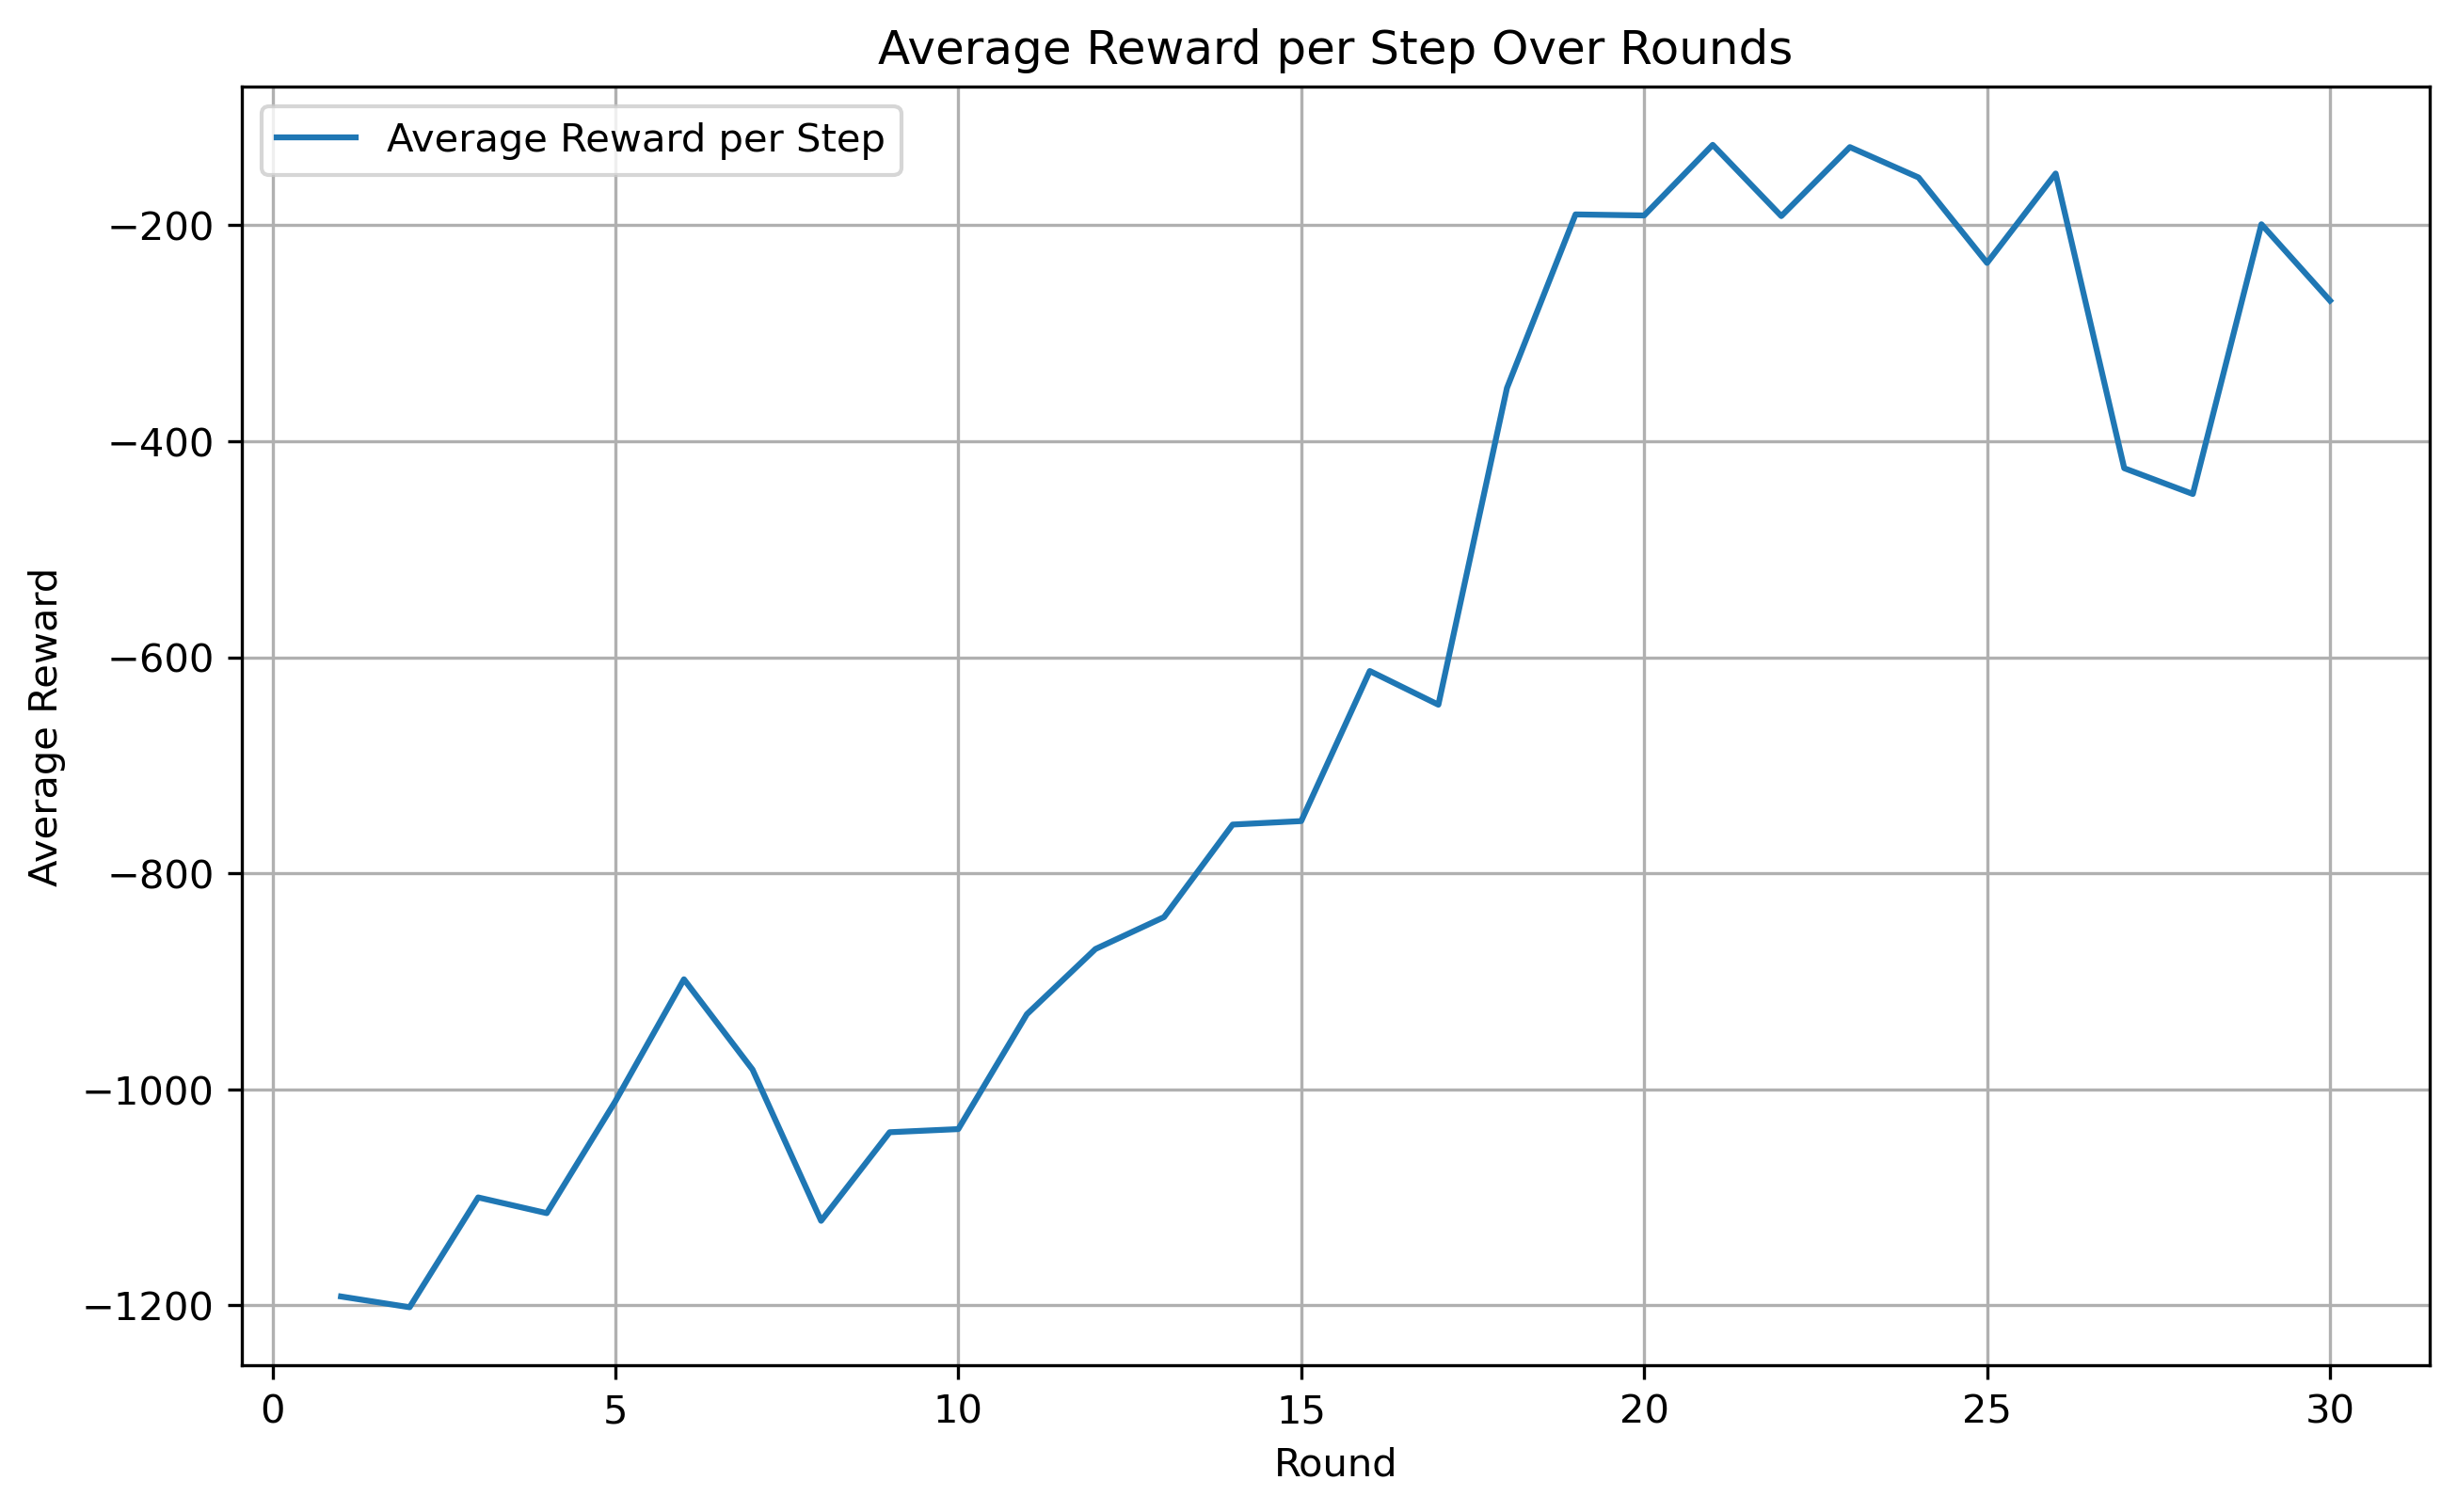

In [14]:
plot_rewards(rewards_log, 500)

In [5]:
Global_RL.env.models

[GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256

In [7]:
Global_RL.env.models

[GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
   )
   (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
 ),
 GaussianModel(
   (fc_net): Sequential(
     (0): Linear(in_features=4, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256

In [42]:
MB_env.reset()

(array([ 0.25910562, -0.965849  ,  0.49215463], dtype=float32), {})

In [43]:
MB_env.obs

array([ 0.25910562, -0.965849  ,  0.49215463], dtype=float32)

In [46]:
MB_env.step(MB_env.action_space.sample())

ValueError: not enough values to unpack (expected 3, got 1)

In [47]:
MB_env.obs

array([[ 0.2085361, -0.7650793, -1.1017272]], dtype=float32)

In [5]:
obs,_ = Clients[0].env.reset()

In [6]:
obs

array([ 0.43307275,  0.90135896, -0.16240236], dtype=float32)

In [7]:
action =  Clients[0].agent.act(obs)

In [9]:
action

array([-0.33290574], dtype=float32)

In [10]:
Clients[0].model

GaussianModel(
  (fc_net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (mean_logvar): Linear(in_features=256, out_features=6, bias=True)
)

In [11]:
obs_tensor = torch.tensor(obs, dtype=torch.float32)
action_tensor = torch.tensor(action, dtype=torch.float32)
input_d = torch.cat((obs_tensor, action_tensor))

In [12]:
input_d

tensor([ 0.4331,  0.9014, -0.1624, -0.3329])

In [13]:
input_d = input_d.to(device)

In [14]:
mean, logvar = Clients[0].model.forward(input_d)

In [48]:
mean, logvar[0]

(tensor([-0.0052, -0.0026,  0.6155], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([-3.5161, -2.7553, -2.9714], device='cuda:0', grad_fn=<SelectBackward0>))

In [52]:
std = torch.exp(0.5 * logvar[0])
std

tensor([0.1724, 0.2522, 0.2263], device='cuda:0', grad_fn=<ExpBackward0>)

In [53]:
eps = torch.randn_like(std)

In [54]:
eps

tensor([0.7962, 0.2781, 1.4486], device='cuda:0')

In [55]:
pred_state_change = mean + eps * std

In [56]:
pred_state_change

tensor([0.1320, 0.0675, 0.9434], device='cuda:0', grad_fn=<AddBackward0>)

In [57]:
output_np = pred_state_change.detach().cpu().numpy()

In [58]:
output_np

array([0.13200563, 0.06751756, 0.94340324], dtype=float32)

In [59]:
obs

array([ 0.43307275,  0.90135896, -0.16240236], dtype=float32)

In [60]:
obs_new = obs + output_np

In [61]:
obs_new

array([0.5650784 , 0.96887654, 0.78100085], dtype=float32)

In [27]:
import numpy as np

In [28]:
obs_clipped = np.clip(obs, Clients[0].env.observation_space.low, Clients[0].env.observation_space.high)

In [29]:
obs_clipped

array([ 0.43307275,  0.90135896, -0.16240236], dtype=float32)

In [41]:
Clients[0].agent.policy_net.predict(obs)[0]

array([-0.30735433], dtype=float32)

In [44]:
from stable_baselines3.common.evaluation import evaluate_policy

In [47]:
# mean_reward, std_reward = evaluate_policy(Global_RL, real_envs[1], n_eval_episodes=10)
mean_reward, std_reward = evaluate_policy(Global_RL, MB_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

D:\Anaconda\envs\py3.8\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: -93.15121025741101 +/- 109.2765889131137


In [55]:
from sb3_contrib import TRPO

In [59]:
TRPO_model = TRPO("MlpPolicy", env=real_envs[0], verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [61]:
TRPO_model.learn(100000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -829     |
| time/              |          |
|    fps             | 520      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -847     |
| time/                     |          |
|    fps                    | 478      |
|    iterations             | 2        |
|    time_elapsed           | 8        |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | 0.715    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00696  |
|    learning_rate          | 0.001    |
|    n_updates              | 50       |
|    policy_objective       | 0.0147   |
|   

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -644     |
| time/                     |          |
|    fps                    | 473      |
|    iterations             | 13       |
|    time_elapsed           | 56       |
|    total_timesteps        | 26624    |
| train/                    |          |
|    explained_variance     | 0.928    |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00833  |
|    learning_rate          | 0.001    |
|    n_updates              | 61       |
|    policy_objective       | 0.0195   |
|    std                    | 0.681    |
|    value_loss             | 334      |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 200      |
|    ep_rew_mean            | -604     |
| time/                     |          |
|    fps        

KeyboardInterrupt: 

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 定义GaussianModel
class GaussianModel(nn.Module):
    def __init__(self, obs_size, action_size, hidden_size=256, learn_logvar_bounds=False):
        super(GaussianModel, self).__init__()
        self.out_size = obs_size
        
        self.fc_net = nn.Sequential(
            nn.Linear(obs_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )
        
        self.mean_logvar = nn.Linear(hidden_size, obs_size * 2)
        
        self.min_logvar = nn.Parameter(
            -10 * torch.ones(1, obs_size), requires_grad=learn_logvar_bounds
        )
        self.max_logvar = nn.Parameter(
            0.5 * torch.ones(1, obs_size), requires_grad=learn_logvar_bounds
        )
        
    def forward(self, x):
        x = self.fc_net(x)
        mean_and_logvar = self.mean_logvar(x)
        mean = mean_and_logvar[..., :self.out_size]
        logvar = mean_and_logvar[..., self.out_size:]
        
        logvar = self.max_logvar - F.softplus(self.max_logvar - logvar)
        logvar = self.min_logvar + F.softplus(logvar - self.min_logvar)
        
        # If the original input was one-dimensional, squeeze the output
        if logvar.shape[0] == 1:
            mean = mean.squeeze(0)
            logvar = logvar.squeeze(0)
        
        return mean, logvar

# 定义测试用例
def test_gaussian_model():
    obs_size = 4
    action_size = 2
    hidden_size = 256

    model = GaussianModel(obs_size, action_size, hidden_size)

    # 单个输入数据
    single_input = torch.randn(obs_size + action_size)
    
    # 批量输入数据
    batch_input = torch.randn(5, obs_size + action_size)
    
    # 前向传播
    single_mean, single_logvar = model(single_input)
    batch_mean, batch_logvar = model(batch_input)
    
    print("Single Input Mean:", single_mean)
    print("Single Input Logvar:", single_logvar)
    print("Batch Input Mean:", batch_mean)
    print("Batch Input Logvar:", batch_logvar)
    
    # 构建损失函数
    loss_fn = nn.MSELoss()
    
    # 构造目标数据
    target_mean = torch.randn(obs_size)
    target_logvar = torch.randn(obs_size)
    
    # 计算损失
    single_loss = loss_fn(single_mean, target_mean) + loss_fn(single_logvar, target_logvar)
    batch_loss = loss_fn(batch_mean, target_mean.unsqueeze(0).expand_as(batch_mean)) + \
                 loss_fn(batch_logvar, target_logvar.unsqueeze(0).expand_as(batch_logvar))
    
    print("Single Input Loss:", single_loss.item())
    print("Batch Input Loss:", batch_loss.item())

# 运行测试用例
test_gaussian_model()


Single Input Mean: tensor([ 0.3523, -0.0157, -0.2429,  0.1068], grad_fn=<SqueezeBackward1>)
Single Input Logvar: tensor([-0.5165, -0.4999, -0.4875, -0.4478], grad_fn=<SqueezeBackward1>)
Batch Input Mean: tensor([[ 0.1343,  0.0868, -0.1983,  0.0582],
        [ 0.1066, -0.1898, -0.6315,  0.0736],
        [ 0.3875,  0.1861, -0.3479,  0.0122],
        [ 0.1715,  0.0231, -0.1943,  0.1135],
        [ 0.2438, -0.0612, -0.4051,  0.0425]], grad_fn=<SliceBackward0>)
Batch Input Logvar: tensor([[-0.4949, -0.4842, -0.5894, -0.4223],
        [-0.4841, -0.3873, -0.6761, -0.3461],
        [-0.5958, -0.4917, -0.8158, -0.3497],
        [-0.4940, -0.4847, -0.5807, -0.4696],
        [-0.4818, -0.4734, -0.7298, -0.3792]], grad_fn=<AddBackward0>)
Single Input Loss: 3.6077818870544434
Batch Input Loss: 3.898193597793579
